In [1]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kaleido
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from IPython.display import display

import os

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import os

def plot_experiments(directory: str,
                     base_path: str = "/home/tvanhout/oxides_ML/models/Experiments/RELAXED",
                     output_path: str = "./experiment_plots/",
                     plot_title: str = None) -> None:
    """
    Generate and save plot showing prediction and error analysis for a given experiment directory.
    """
    os.makedirs(output_path, exist_ok=True)

    # Load data
    df_test_set = pd.read_csv(os.path.join(base_path, directory, "test_set.csv"))
    df_uq = pd.read_csv(os.path.join(base_path, directory, "uq.csv"))

    # Color maps
    color_map_safe = px.colors.qualitative.Safe
    color_map_set2 = px.colors.qualitative.Set2

    # Sort data
    df_test_sorted = df_test_set.sort_values("Material")
    df_uq_sorted1 = df_uq[df_uq["split"] == "test"].sort_values("molecule_group")
    df_uq_sorted2 = df_uq[df_uq["split"] == "test"].sort_values("material")

    # Create subplot
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=[
            "DFT vs Predicted Energy by Material",
            "Error Distribution by Molecular Group",
            "Error Distribution by Material"
        ],
        horizontal_spacing=0.05
    )
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['text.usetex'] = False

    # === Plot 1 ===
    unique_materials = df_test_sorted["Material"].unique()
    for i, material in enumerate(unique_materials):
        subset = df_test_sorted[df_test_sorted["Material"] == material]
        if not subset.empty:
            fig.add_trace(go.Scatter(
                x=subset['True_eV'],
                y=subset['Prediction_eV'],
                mode='markers',
                name=material,
                marker=dict(size=10, color=color_map_safe[i % len(color_map_safe)]),
                hovertemplate=(
                    "<b>Material:</b> %{customdata[0]}<br>" +
                    "<b>Molecule Group:</b> %{customdata[1]}<br>" +
                    "<b>Molecule:</b> %{customdata[2]}<br>" +
                    "<b>State:</b> %{customdata[3]}<br>" +
                    "<b>Dissociation:</b> %{customdata[4]}<br>" +
                    "<b>DFT Energy:</b> %{x:.3f} eV<br>" +
                    "<b>Predicted Energy:</b> %{y:.3f} eV<br>" +
                    "<b>Relative Error:</b> %{customdata[5]} eV<br>" +
                    "<b>Absolute Error:</b> %{customdata[6]} eV<br><extra></extra>"
                ),
                customdata=subset[['Material', 'Molecule Group', 'Molecule', 'State', 'Dissociation', "Error_eV", "Abs_error_eV"]],
                showlegend=False
            ), row=1, col=1)

    # Add 1:1 line
    min_val = df_test_sorted['True_eV'].min()
    max_val = df_test_sorted['True_eV'].max()
    fig.add_trace(go.Scatter(
        x=[min_val, max_val],
        y=[min_val, max_val],
        mode='lines',
        name='1:1 Line',
        line=dict(dash='dash', color='red'),
        showlegend=False
    ), row=1, col=1)

    # === Plot 2 ===
    for i, group in enumerate(df_uq_sorted1['molecule_group'].unique()):
        group_data = df_uq_sorted1[df_uq_sorted1['molecule_group'] == group]
        fig.add_trace(go.Box(
            y=group_data['error'],
            name=group,
            marker_color=color_map_set2[i % len(color_map_set2)],
            boxmean=True,
            boxpoints="all",
            jitter=0.5,
            line=dict(width=3),
            width=0.2,
            legendgroup=group,
            hovertemplate=(
                "Material: %{customdata[7]}<br>" +
                "Molecule Group: %{customdata[0]}<br>" +
                "Molecule: %{customdata[1]}<br>" +
                "State: %{customdata[2]}<br>" +
                "Dissociation: %{customdata[3]}<br>" +
                "DFT Value: %{customdata[4]} eV<br>" +
                "Std Dev: %{customdata[5]} eV<br>" +
                "Error: %{customdata[6]} eV<br><extra></extra>"
            ),
            customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error', 'material']].values,
            showlegend=False
        ), row=1, col=2)

    # === Plot 3 ===
    for i, group in enumerate(df_uq_sorted2['material'].unique()):
        group_data = df_uq_sorted2[df_uq_sorted2['material'] == group]
        fig.add_trace(go.Box(
            y=group_data['error'],
            name=group,
            marker_color=color_map_safe[i % len(color_map_safe)],
            boxmean=True,
            boxpoints="all",
            jitter=0.5,
            line=dict(width=3),
            width=0.2,
            legendgroup=group,
            hovertemplate=(
                "Material: %{customdata[7]}<br>" +
                "Molecule Group: %{customdata[0]}<br>" +
                "Molecule: %{customdata[1]}<br>" +
                "State: %{customdata[2]}<br>" +
                "Dissociation: %{customdata[3]}<br>" +
                "DFT Value: %{customdata[4]} eV<br>" +
                "Std Dev: %{customdata[5]} eV<br>" +
                "Error: %{customdata[6]} eV<br><extra></extra>"
            ),
            customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error', 'material']].values,
            showlegend=False
        ), row=1, col=3)

    # Layout and axes
    fig.update_layout(
        height=700,
        width=2600,
        template="plotly_white",
        title_text=(plot_title + " – MAE: " + str(round(df_test_set["Abs_error_eV"].mean(), 2))) or "Prediction Performance Overview",
        showlegend=True
    )

    # Set x-axis labels and ranges
    fig.update_xaxes(title_text="DFT Energy [eV]", row=1, col=1)
    fig.update_xaxes(title_text="Molecular Group",  showticklabels=True, row=1, col=2)
    fig.update_xaxes(title_text="Material",         showticklabels=True, row=1, col=3)

    # Set y-axis labels and ranges
    fig.update_yaxes(title_text="Predicted Energy [eV]", row=1, col=1)

    min_val = -5
    max_val = 5
    fig.update_yaxes(title_text="Error [eV]", range=[min_val, max_val], row=1, col=2)
    fig.update_yaxes(title_text="Error [eV]", range=[min_val, max_val], row=1, col=3)


    # Save plots
    safe_dir_name = directory.replace("/", "_")
    html_path = os.path.join(output_path, f"{safe_dir_name}_performance.html")
    png_path = os.path.join(output_path, f"{safe_dir_name}_performance.png")
    
    fig.write_image(png_path)
    fig.show()

    print(f"Saved:{png_path}")

    return df_test_sorted, df_uq_sorted1, df_uq_sorted2


def plot_all_experiments(directories: list[str],
                         base_path: str = "/home/tvanhout/oxides_ML/models/Experiments/RELAXED",
                         output_path: str = "./experiment_plots/") -> None:
    """
    Loop through multiple experiment directories and generate/save plots.
    Collect and display MAE values across all directories.
    """
    mae_list = []  # Accumulator for MAE DataFrames

    for directory in directories:
        print(f"Processing: {directory}")
        title = f"Prediction Performance Overview – {directory}"
        
        plot_experiments(directory=directory,
                         base_path=base_path,
                         output_path=output_path,
                         plot_title=title)
        
        generate_MAE_dfs(directory=directory,
                         base_path=base_path)
        
        df_MAE = generate_MAE(directory=directory,
                              base_path=base_path)
        mae_list.append(df_MAE)  # Append each result

    # Concatenate all into a single DataFrame
    full_df_MAE = pd.concat(mae_list, ignore_index=True)

    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=full_df_MAE, x="Directory", y="MAE [eV]", hue="Directory", palette="viridis", legend=True)

    # Remove x-axis tick labels if needed
    ax.set_xticklabels([])  # or use `ax.set_xticks([])` if you want no ticks at all
    ax.set_xlabel("Run")

    # Move the legend outside the box
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Show the plot
    plt.show()

    display(full_df_MAE)
        
def generate_MAE_dfs(directory: str,
                     base_path: str = "/home/tvanhout/oxides_ML/models/Experiments/RELAXED",
                     ) -> None:
    """
    Generate dfs to store MAE per material and molecule group.
    """
    # Load data
    df_test_set = pd.read_csv(os.path.join(base_path, directory, "test_set.csv"))
    df_uq = pd.read_csv(os.path.join(base_path, directory, "uq.csv"))

    df_MAE_material = df_test_set.groupby("Material")[["Abs_error_eV"]].mean().reset_index()
    df_MAE_material.rename(columns={"Abs_error_eV": "MAE [eV]"}, inplace=True)

    df_MAE_molecule_group = df_test_set.groupby("Molecule Group")[["Abs_error_eV"]].mean().reset_index()
    df_MAE_molecule_group.rename(columns={"Abs_error_eV": "MAE [eV]"}, inplace=True)

    display(df_MAE_material)
    display(df_MAE_molecule_group)


def generate_MAE(directory: str,
                 base_path: str = "/home/tvanhout/oxides_ML/models/Experiments/RELAXED",
                 ) -> None:
    """
    Generate a DataFrame to store MAE for the given directory.
    Saves a CSV file with the MAE value for later aggregation or inspection.
    """
    df_test_set = pd.read_csv(os.path.join(base_path, directory, "test_set.csv"))

    mae_value = df_test_set["Abs_error_eV"].mean()
    
    df_MAE = pd.DataFrame({"Directory": [directory], "MAE [eV]": [mae_value]})

    return df_MAE


Processing: Db2_TiO2_base


Saved:./experiment_plots/Db2_TiO2_base_performance.png


,Material,MAE [eV]
0,IrO2,0.176344
1,RuO2,0.160485
2,TiO2,0.115874


,Molecule Group,MAE [eV]
0,alcohols_aldehydes_ketones_ethers,0.152638
1,alkanes_alkenes_alkynes,0.147906
2,amides,0.128385
3,amidines,0.109066
4,amines,0.126046
5,carbamate-esters,0.116471
6,carbonates_carboxylic-acids_esters,0.167957
7,imines,0.139513
8,oximes,0.122020
9,thiols_thials_thioketones_thioethers,0.196332


Processing: Db2_TiO2_test


Saved:./experiment_plots/Db2_TiO2_test_performance.png


,Material,MAE [eV]
0,IrO2,0.201563
1,RuO2,0.164697
2,TiO2,0.122311


,Molecule Group,MAE [eV]
0,alcohols_aldehydes_ketones_ethers,0.162339
1,alkanes_alkenes_alkynes,0.149536
2,amides,0.142435
3,amidines,0.120251
4,amines,0.147661
5,carbamate-esters,0.113590
6,carbonates_carboxylic-acids_esters,0.176808
7,imines,0.152860
8,oximes,0.108414
9,thiols_thials_thioketones_thioethers,0.226090


Processing: Db2_TiO2_test2


Saved:./experiment_plots/Db2_TiO2_test2_performance.png


,Material,MAE [eV]
0,IrO2,0.217832
1,RuO2,0.179797
2,TiO2,0.126799


,Molecule Group,MAE [eV]
0,alcohols_aldehydes_ketones_ethers,0.172953
1,alkanes_alkenes_alkynes,0.170183
2,amides,0.149010
3,amidines,0.112635
4,amines,0.146131
5,carbamate-esters,0.127077
6,carbonates_carboxylic-acids_esters,0.173550
7,imines,0.170904
8,oximes,0.098061
9,thiols_thials_thioketones_thioethers,0.252760


Processing: Db2_TiO2_test3


Saved:./experiment_plots/Db2_TiO2_test3_performance.png


,Material,MAE [eV]
0,IrO2,0.225918
1,RuO2,0.185813
2,TiO2,0.135954


,Molecule Group,MAE [eV]
0,alcohols_aldehydes_ketones_ethers,0.206641
1,alkanes_alkenes_alkynes,0.166216
2,amides,0.144663
3,amidines,0.109025
4,amines,0.143713
5,carbamate-esters,0.104108
6,carbonates_carboxylic-acids_esters,0.188387
7,imines,0.182539
8,oximes,0.133083
9,thiols_thials_thioketones_thioethers,0.253159


Processing: Db2_TiO2_test4


Saved:./experiment_plots/Db2_TiO2_test4_performance.png


,Material,MAE [eV]
0,IrO2,0.228428
1,RuO2,0.180314
2,TiO2,0.149900


,Molecule Group,MAE [eV]
0,alcohols_aldehydes_ketones_ethers,0.187309
1,alkanes_alkenes_alkynes,0.162879
2,amides,0.155437
3,amidines,0.162345
4,amines,0.194431
5,carbamate-esters,0.122278
6,carbonates_carboxylic-acids_esters,0.166454
7,imines,0.176637
8,oximes,0.093918
9,thiols_thials_thioketones_thioethers,0.265424


Processing: Db2_TiO2_test5


Saved:./experiment_plots/Db2_TiO2_test5_performance.png


,Material,MAE [eV]
0,IrO2,0.221082
1,RuO2,0.179049
2,TiO2,0.132098


,Molecule Group,MAE [eV]
0,alcohols_aldehydes_ketones_ethers,0.175344
1,alkanes_alkenes_alkynes,0.124602
2,amides,0.142280
3,amidines,0.166081
4,amines,0.153569
5,carbamate-esters,0.084969
6,carbonates_carboxylic-acids_esters,0.267228
7,imines,0.143436
8,oximes,0.197119
9,thiols_thials_thioketones_thioethers,0.258090


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

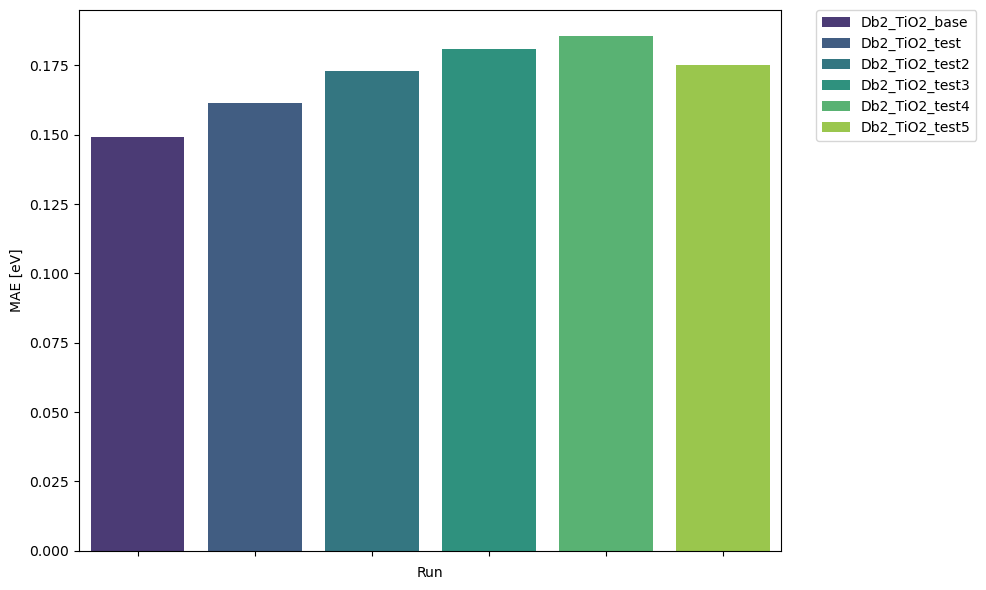

,Directory,MAE [eV]
0,Db2_TiO2_base,0.149233
1,Db2_TiO2_test,0.161603
2,Db2_TiO2_test2,0.172942
3,Db2_TiO2_test3,0.180785
4,Db2_TiO2_test4,0.185718
5,Db2_TiO2_test5,0.175337


In [2]:
dirs = ["Db1_TiO2_base", "Db1_TiO2_test", "Db1_TiO2_test2", "Db1_TiO2_test3", "Db1_TiO2_test4", "Db1_TiO2_test5"]
dirs = ["Db2_TiO2_base", "Db2_TiO2_test", "Db2_TiO2_test2", "Db2_TiO2_test3", "Db2_TiO2_test4", "Db2_TiO2_test5"]
# dirs = ["Db3_TiO2_base", "Db3_TiO2_test", "Db3_TiO2_test2", "Db3_TiO2_test3", "Db3_TiO2_test4", "Db3_TiO2_test5"]
plot_all_experiments(dirs, "/home/tvanhout/oxides_ML/models/Experiments/RELAXED/tolerance_fixed")

In [3]:
# from torch_geometric.data import InMemoryDataset, Data
# from torch import load, save, tensor
# import torch
# import sys

# # Add src folder to the sys.path
# src_path = "../src"
# sys.path.insert(0, src_path)

# from oxides_ml.graph_tools import graph_plotter


# # path_to_zip = "/home/tvanhout/oxides_ML/models/test_graph_datasets/oxide_adsorbates_adsorption_energy_03_125_2_False_False_False_False_False_False_relaxed_False"
# path_to_zip = "/home/tvanhout/oxides_ML/models/graph_datasets/database_3_adsorption_energy_029_125_2_False_False_False_True_False_False_relaxed_False"
# data, slices = load(path_to_zip, weights_only=False)

# # Temporarily create a dummy class instance to access the get functionality
# dataset = InMemoryDataset()
# dataset.data = data
# dataset.slices = slices

# for graph in range(len(dataset)):
#     if (dataset[graph].adsorbate_name == "Methanethial") and (dataset[graph].material == "IrO2") and (dataset[graph].ads_energy < -0.5) and (dataset[graph].ads_energy > -0.9):
#         graph_plotter(dataset[graph])